## PHYS-467 Machine Learning for Physicists. Exercise session 4

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle, os
from urllib.request import urlopen 

from sklearn.linear_model import LinearRegression,LogisticRegression, Ridge, Lasso, RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

np.random.seed(42)

# Exercise 1 : (Stochastic) Gradient Descent with Logistic regression

**Question 1.a)** Implement the sigmoid function $\sigma(x)$

In [45]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

**Question 1.b)** Generate an $n\times{d}$ random data matrix with dimension $d = 2$. Generate a random vector of optimal parameters $w_{opt}$. Generate the labels as $y = \pm 1$ from the distribution $p(y = 1 | x) = 1 - p(y = -1 | x) = \sigma(w_{opt}^Tx)$. 

In [46]:
n = 100
d = 2

w_opt = np.random.normal(size=d)
X     = np.random.normal(size=(n,d))
y     = 2 * np.random.binomial(1,sigmoid(X @ w_opt)) - 1.0

**Question 1.c)** Verify that sigmoid(x) = 1-sigmoid(x)

In [47]:
print(sigmoid(X[1]))
print(1-sigmoid(-X[1]))

[0.44172766 0.44173171]
[0.44172766 0.44173171]


**Question 1.d)** Implement a function performing one step gradient descent for logistic regression. Recall that with $y = \pm 1$,  the logistic loss is $\mathcal L = - \sum_i \log \sigma(y_i \times w^T x_i)$. Implement a second function enabling multiple iterations of gradient descent. This function should return the parameters calculated at each iteration.

In [48]:
def gradient_step_logistic(X, y, w_, lr=0.01):
    """One step gradient descent for logistic regression"""
    #return w - lr * np.einsum('ij,j->i', X.T,(sigmoid(y * (X @ w)) - 1.0)*y)
    return w_ - lr * (X.T@((sigmoid(y*(X@w_))-1)*y))

def gradient_descent_logistic(X, y, w_init, lr=0.01, n_iter=100):
    """Gradient descent for logistic regression with multiple iterations"""
    w = w_init
    ws = []
    for i in range(n_iter):
        w = gradient_step_logistic(X, y, w, lr) #gradient of logistic loss with y = -1 or y = 1
        ws.append(w)
    return ws

**Question 1.e)** Implement stochastic gradient descent using the gradient step function used in the previous question. Hint: you should apply the gradient step function only on a random subset of the data at each iteration.

In [49]:
def stochastic_gradient_descent_logistic(X, y, w_init, lr=0.01, n_iter=100, batch_size = 10):
    w = w_init
    ws = []
    for i in range(n_iter):
        indices = np.random.randint(0, X.shape[0], size=batch_size)
        w = gradient_step_logistic(X[indices], y[indices], w, lr)
        ws.append(w)
    return ws

**Question 1.f)** Run GD and SGD with a small learning rate $\eta$ ($10^{-2}$ should work fine). Plot $\ cos (\frac{w_t \cdot w_{\star}}{\vert{w_t}\vert\vert{w_{\star}\vert}})$ as a function of the number of iterations $t$ for Gradient Descent and Stochastic Gradient Descent. 

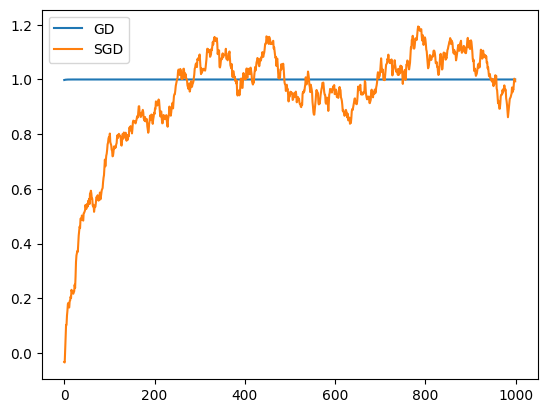

In [50]:
ws_gd  = gradient_descent_logistic(X, y, np.zeros(d), lr=1e-2, n_iter=1000)
ws_sgd = stochastic_gradient_descent_logistic(X, y, np.zeros(d), lr=1e-2, n_iter=1000)

plt.plot(ws_gd @ w_opt / (np.linalg.norm(ws_gd, axis=1)* np.linalg.norm(w_opt)), label='GD')
plt.plot(ws_sgd @ w_opt / (np.linalg.norm(ws_gd, axis=1)* np.linalg.norm(w_opt)), label='SGD')
plt.legend()
plt.show()

**Question 1.g)** Use sklearn's LogisticRegression with fit_intercept=False and compare its accuracy with that obtained by gd and the optimal parameters.

In [51]:
logistic_regression = LogisticRegression(fit_intercept=False)
lr = logistic_regression.fit(X,y)

**Question 1.h)** In this question we look at the role of the learning rate in the convergence of gradient descent. Run GD with a large learning rate (say $\eta$ = 10.0), and observe that GD does not converge.

In [52]:
print(np.sum(((2*(sigmoid(X@lr.coef_[0])>0.5).astype(int))-1==y))/len(y))
print(np.sum(((2*(sigmoid(X@ws_gd[-1])>0.5).astype(int))-1==y))/len(y))
print(np.sum(((2*(sigmoid(X@w_opt)>0.5).astype(int))-1==y))/len(y))

0.62
0.62
0.62


# Exercise 2: LASSO

**Question 2.a)** Generate a $n\times{d}$ matrix with entries drawn from a Gaussian with zero mean and unit variance. Choose $n=300$ and $d=10$.

In [53]:
rng = np.random.RandomState(42)
n = 300
d = 10
X_train = rng.randn(n, d)

**Question 2.b)** Given the vector $w_{opt}$ provided below, print it and use it to generate the training and testing labels. Corrupt the labels with zero-mean unit-variance Gaussian noise

In [54]:
w_opt = rng.choice([0,1,-1],d,p=[0.7,0.15,0.15])
print(w_opt)
y_train = X_train@w_opt+ 1*rng.randn(n)

[ 1 -1  0 -1  0  0  0  0  0  0]


**Question 2.c)** Perform linear regression on the training data and print: a) the so-found coefficients and the train error

In [55]:
linear_regression = LinearRegression(fit_intercept=False)
l_r = linear_regression.fit(X_train,y_train)
print(l_r.coef_)
print(np.mean((l_r.predict(X_train)-y_train)**2))

[ 0.9810048  -0.96923952  0.03324104 -0.98097451  0.06136124  0.03222384
 -0.04996516 -0.00965523  0.03963248 -0.04502694]
1.0240993371444587


**Question 2.d)** Fit sklearn's LASSO on the training data and print: a) the so-found coefficients and the train error. Fix the regularization to 0.1. Look at the coefficients, what do you notice?

In [56]:
lasso = Lasso(fit_intercept=False,alpha=0.1)
l_r = lasso.fit(X_train,y_train)
print(l_r.coef_)
print(np.mean((l_r.predict(X_train)-y_train)**2))

[ 0.86307721 -0.86313438  0.         -0.86677229  0.          0.
 -0.         -0.          0.         -0.        ]
1.070432341791993


**Question 2.e)** Use cross validation to find the optimal value of the regularization strength in Lasso. Plot the different coefficients as a function of $\lambda$ 

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1474: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider i

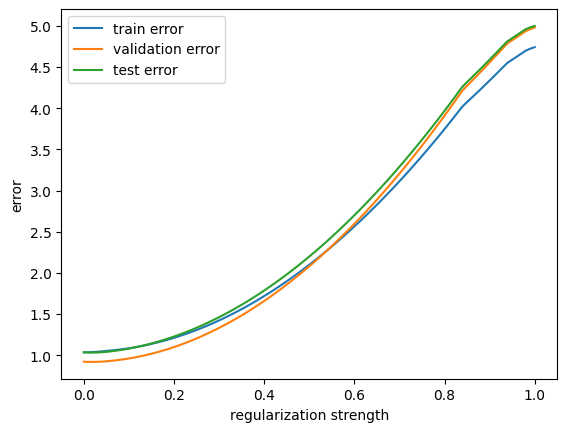

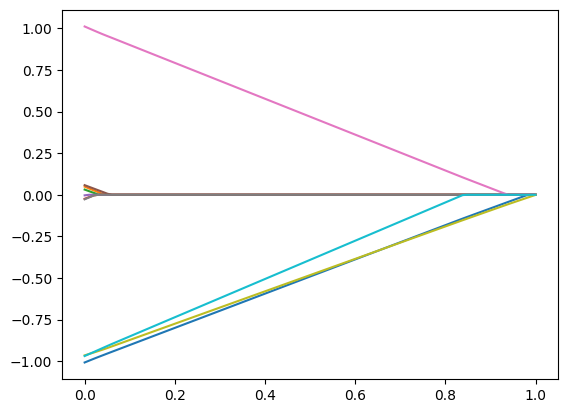

In [57]:
rng = np.random.RandomState(10)
n = 1000
d = 10
X_train = rng.randn(n, d)
X_val = rng.randn(n, d)
X_test = rng.randn(n, d)

w_opt = rng.choice([0,1,-1],d,p=[0.7,0.15,0.15])
#print(w_opt)
y_train = X_train @ w_opt + rng.randn(n)
y_val = X_val @ w_opt + rng.randn(n)
y_test = X_test @   w_opt + rng.randn(n)

lambdas = np.linspace(0, 1.0, 100)
train_errors=[]
val_errors=[]
test_errors=[]
ws = []

for l in lambdas:
    lasso = Lasso(fit_intercept=False,alpha=l)
    l_r = lasso.fit(X_train,y_train)
    ws.append(l_r.coef_)
    train_errors.append(np.mean((l_r.predict(X_train)-y_train)**2))
    val_errors.append(np.mean((l_r.predict(X_val)-y_val)**2))
    test_errors.append(np.mean((l_r.predict(X_test)-y_test)**2))

plt.plot(lambdas,train_errors, label='train error')
plt.plot(lambdas,val_errors, label='validation error')
plt.plot(lambdas,test_errors, label='test error')
plt.xlabel('regularization strength')
plt.ylabel('error')
plt.legend()
plt.show()

# plot the coefficients 

plt.plot(lambdas, ws) 
plt.show()

In [58]:
lambdas[np.argmin(val_errors)]
print(ws[np.argmin(val_errors)])
print(w_opt)

[-0.98496926  0.02637582  0.01134308 -0.00393351 -0.          0.03720723
  0.9868559  -0.00410678 -0.94726365 -0.94413589]
[-1  0  0  0  0  0  1  0 -1 -1]


# Exercise 3: Ridge Classification, Logistic Regression

In this exercise we first consider a synthetic dataset to compare Ridge and Logistic regression for classification

**Question 3.a)** Use the sklearn function make_classification to generate 1000 data samples in 2 dimension. Use the following arguments: n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=12. Then use train_test_split with the following arguments X, y, test_size=0.2, random_state=42, to generate training and test splits.

In [59]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Question 3.b)** Make a scatter plot of the training data. Color each point according to its cluster assignment. _Hint_ : To change the color as a function of the label, use the option `c=y` in `plt.scatter`.

Text(0, 0.5, '$x_2$')

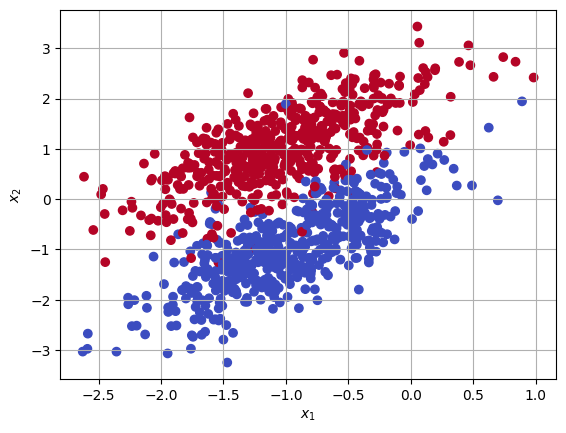

In [60]:
# scatter X and color the points depending on their class
plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm')
plt.grid()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

**Question 3.c)** Train a ridge classifier and a logistic regression using sklearn. Compare the results in terms of accuracy.

In [61]:
# Create and train a Ridge Classifier
ridge_classifier = RidgeClassifier()
ridge_classifier.fit(X_train, y_train)

# Create and train a Logistic Regression model
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

# Make predictions using both models
y_pred_ridge = ridge_classifier.predict(X_test)
y_pred_logistic = logistic_regression.predict(X_test)

# Calculate accuracy for both models
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)


**Question 3.d)** Plot the decision boundaries of the two models 

In [62]:
def plot_decision_boundaries(X_test,y_test,ridge_classifier, logistic_regression, accuracy_ridge,accuracy_logistic):
    """
    arguments : 
        - X_test, y_test : test data
        - ridge_classifier : instance of the class RidgeClassifier
        - logistic_regression : instance of the class LogisticRegression
        - accuracy_ridge : accuracy of the ridge classifier
        - accuracy_logistic : accuracy of the logistic regression
    """
    # Plot the decision boundary for Ridge Classifier
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm')
    plt.title(f"Ridge Classifier\nAccuracy: {accuracy_ridge:.2f}")
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))
    Z = ridge_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k')
    
    # Plot the decision boundary for Logistic Regression
    plt.subplot(1, 2, 2)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm')
    plt.title(f"Logistic Regression\nAccuracy: {accuracy_logistic:.2f}")
    ax = plt.gca()
    Z = logistic_regression.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.8)
    
    plt.show()

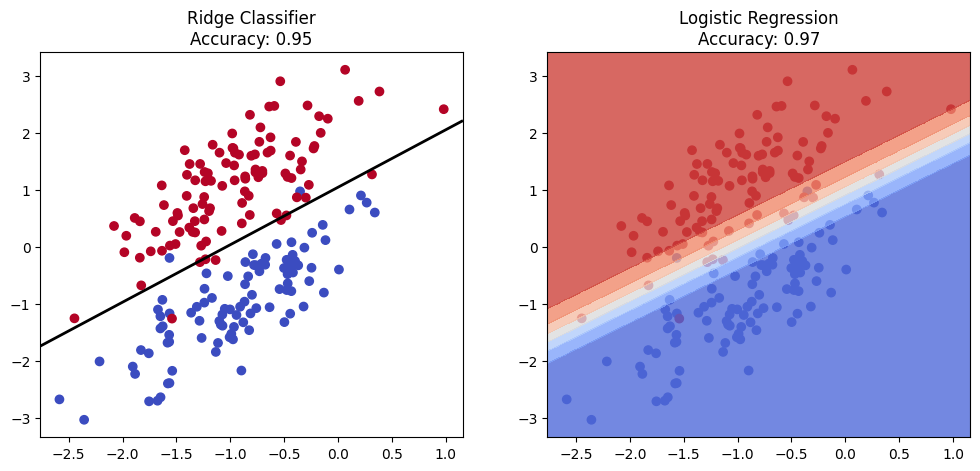

In [63]:
plot_decision_boundaries(X_test,y_test,ridge_classifier,logistic_regression,accuracy_ridge,accuracy_logistic)

**Question 3.e)** Implement ridge classification from scratch. Implement two functions: one should return the weights and biases, the other should return the classification results given the inputs and the previously obtained coefficients. Add the option to include a regularization parameter.

In [64]:
def ridge_train(X,y,alpha):
    n_samples, n_features = X.shape
    X_augmented = np.column_stack((X, np.ones(n_samples)))  # Add a bias term

    identity_matrix = np.eye(n_features + 1)
    coefficients = np.linalg.inv(X_augmented.T @ X_augmented + alpha * identity_matrix) @ X_augmented.T @ y

    coef_ = coefficients[:-1]
    intercept_ = coefficients[-1]
    return coef_, intercept_

def ridge_predict(X,coef_,intercept_):
    preds = X @ coef_ + intercept_
    return np.sign(preds)

**Question 3.f)** Plot the decision boundary and compare it with that obtained via sklearn. Use alpha = 1.

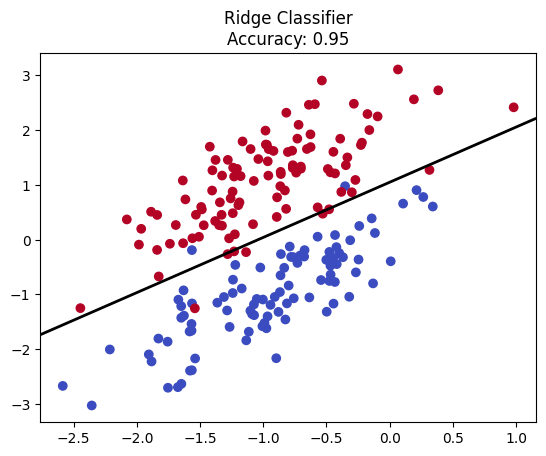

In [65]:
# Create and train a Ridge Classifier
coef_, intercept_ = ridge_train(X_train, ((y_train-0.5)*2),alpha=1)
y_pred_ridge_custom = ridge_predict(X_test,coef_,intercept_)

plt.figure()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm')
plt.title(f"Ridge Classifier\nAccuracy: {np.sum(y_pred_ridge_custom==((y_test-0.5)*2))/(len(y_test)):.2f}")
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))
Z = ridge_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k')

# Exercise 4: Classification on the Ising model 

We will now apply regression to the Ising model to predict the phase of the system. 

In [66]:
# Ising model parameters

L=40 # linear system size
J=-1.0 # Ising interaction
#T=np.linspace(0.25,4.0,16) # set of temperatures
T_c=2.26 # Onsager critical temperature in the TD limit

**Question 4.a)**

1) Load the data using the provided function `load_data`, then split the data in three categories : the first **70000** samples are configurations in the **ordered** phase, the next **30000** samples are in the **critical** phase and the last **60000** samples are in the **disordered** phase.

2) Merge the ordered and disordered samples together, use half of them for a training set and the rest for a validation set.

In [67]:
def load_data():
    """
    Loads the data of the Ising model. The labels correspond to ordered (1) and disordered states (0).
    """
    # url to data
    url_main = 'https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/';
    ######### LOAD DATA
    # The data consists of 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25):
    data_file_name = "Ising2DFM_reSample_L40_T=All.pkl" 
    # The labels are obtained from the following file:
    label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"
    #DATA
    data = pickle.load(urlopen(url_main + data_file_name)) # pickle reads the file and returns the Python object (1D array, compressed bits)
    data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
    data=data.astype('int')
    data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

    #LABELS (convention is 1 for ordered states and 0 for disordered states)
    labels = pickle.load(urlopen(url_main + label_file_name)) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)
    return data, labels


In [68]:
data, labels = load_data()
print(len(data))

###### define ML parameters
num_classes=2
train_to_test_ratio=0.5 # training samples

# divide data into ordered, critical and disordered
X_ordered=data[:70000,:]
Y_ordered=labels[:70000]

X_critical=data[70000:100000,:]
Y_critical=labels[70000:100000]

X_disordered=data[100000:,:]
Y_disordered=labels[100000:]

# define training and test data sets
X=np.concatenate((X_ordered,X_disordered))
Y=np.concatenate((Y_ordered,Y_disordered))

# pick random data points from ordered and disordered states 
# to create the training and test sets
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)

# full data set
X=np.concatenate((X_critical,X))
Y=np.concatenate((Y_critical,Y))

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_critical.shape[0], 'critical samples')
print(X_test.shape[0], 'test samples')

160000
X_train shape: (65000, 1600)
Y_train shape: (65000,)

65000 train samples
30000 critical samples
65000 test samples


**Question 4.b)** Plot one instance of each class

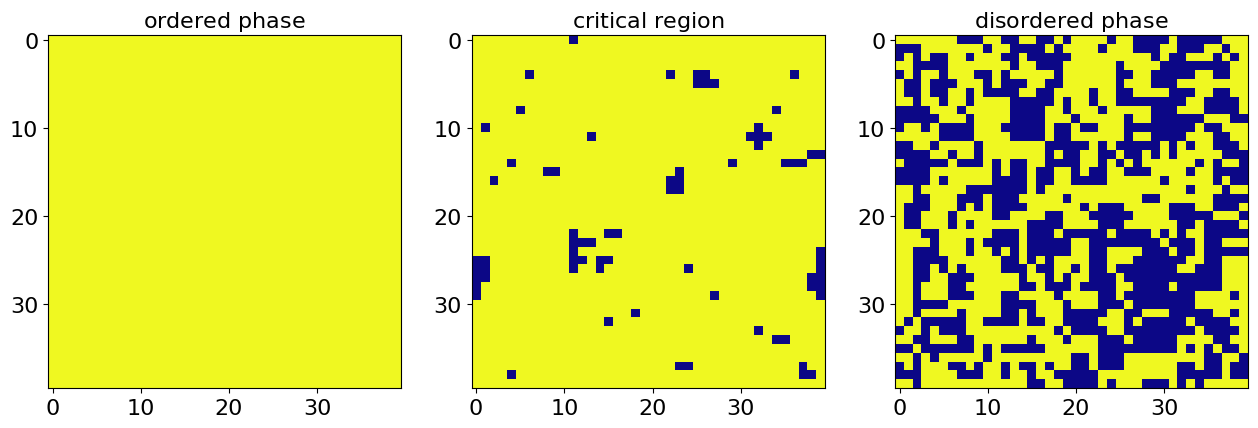

In [69]:
# set colourbar map
cmap_args=dict(cmap='plasma_r')

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(X_ordered[20001].reshape(L,L),**cmap_args)
axarr[0].set_title('$\\mathrm{ordered\\ phase}$',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(X_critical[1000].reshape(L,L),**cmap_args)
axarr[1].set_title('$\\mathrm{critical\\ region}$',fontsize=16)
axarr[1].tick_params(labelsize=16)

im=axarr[2].imshow(X_disordered[50000].reshape(L,L),**cmap_args)
axarr[2].set_title('$\\mathrm{disordered\\ phase}$',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

**Question 4.c)** Train a Ridge and Logistic regression model using different regularization and evaluate the performance on the validation set and the samples in the critical phase. What do you notice ?
_Note_ : Training the models might take some time 

20it [02:28,  7.44s/it]


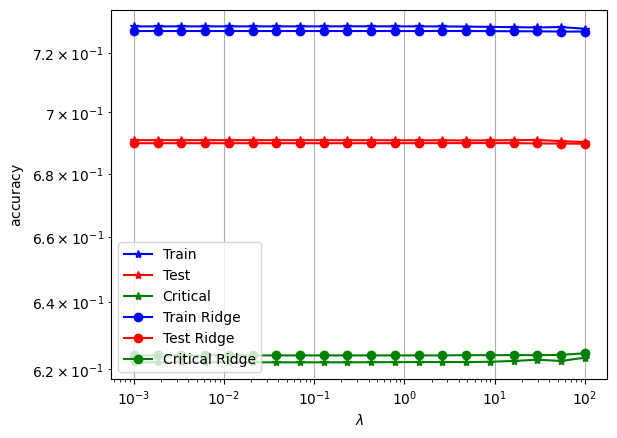

In [70]:
# define regularisation parameter
lmbdas=np.logspace(-3,2,20)

# preallocate data
train_accuracy_log=np.zeros(lmbdas.shape,np.float64)
test_accuracy_log=np.zeros(lmbdas.shape,np.float64)
critical_accuracy_log=np.zeros(lmbdas.shape,np.float64)

train_accuracy_ridge   =np.zeros(lmbdas.shape,np.float64)
test_accuracy_ridge    =np.zeros(lmbdas.shape,np.float64)
critical_accuracy_ridge=np.zeros(lmbdas.shape,np.float64)

# loop over regularisation strength
for i,lmbda in tqdm(enumerate(lmbdas)):

    # define logistic regressor
    logreg= LogisticRegression(C=1.0/lmbda)
    ridge = RidgeClassifier(alpha = lmbda)

    # fit training data
    logreg.fit(X_train, Y_train)
    ridge.fit(X_train, Y_train)

    # check accuracy
    train_accuracy_log[i]=logreg.score(X_train,Y_train)
    test_accuracy_log[i]=logreg.score(X_test,Y_test)
    critical_accuracy_log[i]=logreg.score(X_critical,Y_critical)

    train_accuracy_ridge[i]=ridge.score(X_train,Y_train)
    test_accuracy_ridge[i]=ridge.score(X_test,Y_test)
    critical_accuracy_ridge[i]=ridge.score(X_critical,Y_critical)

# plot accuracy against regularisation strength
plt.semilogx(lmbdas,train_accuracy_log,'*-b',label='Train')
plt.semilogx(lmbdas,test_accuracy_log,'*-r',label='Test')
plt.semilogx(lmbdas,critical_accuracy_log,'*-g',label='Critical')

plt.semilogx(lmbdas,train_accuracy_ridge,'o-b',label='Train Ridge')
plt.semilogx(lmbdas,test_accuracy_ridge,'o-r',label='Test Ridge')
plt.semilogx(lmbdas,critical_accuracy_ridge,'o-g',label='Critical Ridge')

plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')
plt.yscale('log')
plt.grid()
plt.legend()

plt.show()

# Exercise Extra : Linear Regression (clarifications)

In this first exercise, we'll clarify the link between Gradient Descent, the pseudo-inverse and regularization for Ridge regression

**Question E.a)** Generate a random $n\times{d}$ data matrix $X$ where $n=5$ and $d=10$. Generate an $n-$ dimensional _random_ label vector $y$.

In [71]:
n = 5
d = 10
X = np.random.randn(n, d)
y = np.random.randn(n)                                                                

**Question E.b)** Use sklearn's LinearRegression to solve the OLS problem on the previously generated data. Use the option fit_intercept=False.

In [72]:
linear_regression = LinearRegression(fit_intercept=False)
l_r = linear_regression.fit(X,y)

**Question E.c)** Recall that the OLS solution is given by $w = (X^TX)^{-1}X^Ty$. Note that when $n<d$, the matrix $X^TX$ is not invertible and we should resort to the pseudoinverse of $X$. In this case the solution reads $w = X^T(XX^T)^{-1}y$. Write a function that returns the solution calculated in this way and compare the so-obtained coefficients with those obtained by sklearn. What can you conclude?

In [73]:
def linear_regression_pi(X, y):
    """
    arguments:
        - X : data matrix
        - y : output
    returns:
        - w : the least square estimator
    """
    w = X.T@np.linalg.inv(X.dot(X.T)).dot(y)
    return w

**Question E.c)** Another way to make the matrix invertible is to do Ridge Regression. Implement a function returning the regularized solution and compare with the solution obtained by sklearn's Ridge, use $\lambda=1$ for both cases.

In [74]:
print(l_r.coef_)
print(linear_regression_pi(X,y))

def linear_regression_ridge(X, y, reg=1):
    """
    arguments:
        - X : data matrix
        - y : output
    returns:
        - w : the least square estimator
    """
    w = (np.linalg.inv(X.T.dot(X)+reg*np.eye(X.shape[1]))@X.T).dot(y)
    return w

ridge_regression = Ridge(fit_intercept=False, alpha=1)
l_r = ridge_regression.fit(X,y)

print(l_r.coef_)
print(linear_regression_ridge(X,y))

[-0.54236326  0.21616801 -0.52866574 -0.62285233  0.16784139 -0.02773414
 -0.49616948  0.21430901  0.0528699   0.09693682]
[-0.54236326  0.21616801 -0.52866574 -0.62285233  0.16784139 -0.02773414
 -0.49616948  0.21430901  0.0528699   0.09693682]
[-0.47999555  0.23624848 -0.43047833 -0.51841265  0.13632264  0.00492857
 -0.44262623  0.13607812  0.04227164  0.08313062]
[-0.47999555  0.23624848 -0.43047833 -0.51841265  0.13632264  0.00492857
 -0.44262623  0.13607812  0.04227164  0.08313062]


**Question E.d)** Use a small regularization parameter, say $\lambda = 0.001$ and compare the output of Ridge regression with the pseudo-inverse. What do you notice ?

In [75]:
ridge_regression = Ridge(fit_intercept=False, alpha=1e-3)
l_r = ridge_regression.fit(X,y)
print(linear_regression_pi(X,y))
print(l_r.coef_)

[-0.54236326  0.21616801 -0.52866574 -0.62285233  0.16784139 -0.02773414
 -0.49616948  0.21430901  0.0528699   0.09693682]
[-0.54229171  0.21620903 -0.52853753 -0.62271758  0.16779775 -0.02768752
 -0.49611263  0.2141959   0.05285779  0.09692084]


**Question E.e)** Compute the square error on the training data, obtained by using the pseudoinverse coefficient and the error obtained with the regularised coefficient (with $\lambda = 0.1$). Which one do you expect to be smaller?

In [76]:
ridge_regression = Ridge(fit_intercept=False, alpha=0.1)
l_r = ridge_regression.fit(X,y)

w_pi = linear_regression_pi(X,y)
error_ridge = np.mean((l_r.predict(X)-y)**2)
print(error_ridge)

error_pi = np.mean((X@w_pi-y)**2)
print(error_pi)

0.0004663317147997866
1.1093356479670479e-31


**Question E.f)** Consider the OLS problem and implement a function performing one step of gradient descent w.r.t. the parameters. Implement a second function calling the first function for M iterations and finally returning the optimal parameters.

In [77]:
def gradient_descent_step(X,y,w,eta):
    """
    Do one gradient step of OLS
    """
    grad = X.T@(X@w-y)
    w = w - eta * grad 
    return w

def train(n_iter,X,y,w,eta):
    for i in tqdm(range(n_iter)):
        w = gradient_descent_step(X,y,w,eta)
    return w
w_init_1 = np.random.randn(d)
w_b = train(5000,X,y,w_init_1,0.01)
print(w_b)

100%|██████████| 5000/5000 [00:00<00:00, 155041.40it/s]

[ 0.07420638  1.20993448  0.13243572  0.14071893  1.72999223 -0.6232604
 -1.1887397   1.3039522  -0.14136949  1.11909652]


**Question E.g)** Compute 1) $w_a$ the parameters obtained by initializing gradient descent with a vector of zeroes, and $w_b$ the parameters obtained by initializing gradient descent with a vector of ones. Compare both $w_a$ and $w_b$ with the solution obtained by the pseudo-inverse. What do you notice ?

In [78]:
w_init_0 = np.zeros(d)
w_a = train(5000,X,y,w_init_0,0.01)
print(w_a)
print(w_pi)

# == 

w_init_1 = np.ones(d)
w_b = train(5000,X,y,w_init_1,0.01)
print(w_b)
print(w_pi)


100%|██████████| 5000/5000 [00:00<00:00, 148902.10it/s]


[-0.54236326  0.21616801 -0.52866574 -0.62285233  0.16784139 -0.02773414
 -0.49616948  0.21430901  0.0528699   0.09693682]
[-0.54236326  0.21616801 -0.52866574 -0.62285233  0.16784139 -0.02773414
 -0.49616948  0.21430901  0.0528699   0.09693682]


100%|██████████| 5000/5000 [00:00<00:00, 182529.29it/s]

[-0.45477344  1.20067878  0.18107404 -0.23419888  0.85329947 -0.12799853
 -0.27952298  1.38625618  1.16726236  1.45413341]
[-0.54236326  0.21616801 -0.52866574 -0.62285233  0.16784139 -0.02773414
 -0.49616948  0.21430901  0.0528699   0.09693682]


**Question E.h)** Generate a random data $n\times{d}$ matrix $X$ where $n=10$ and $d=5$. Generate an $n-$dimensional label vector $y$.

In [79]:
n = 10
d = 5
X = np.random.randn(n, d)
y = np.random.randn(n)

**Question E.i)** Use sklearn's LinearRegression to solve the OLS problem on the previously generated data. Use the option fit_intercept=False.

In [80]:
linear_regression = LinearRegression(fit_intercept=False)
l_r = linear_regression.fit(X,y)

**Question E.l)** Write a function returning the standard OLS solution and compare it with the sklearn's solution

In [81]:
def linear_regression(X, y):
    """
    arguments:
        - X : data matrix
        - y : output
    returns:
        - w : the least square estimator
    """
    w = np.linalg.inv(X.T.dot(X))@X.T.dot(y)
    return w

print(linear_regression(X,y))
print(l_r.coef_)

[-0.63717872  0.26537203 -0.18045654  0.00653801  0.15365204]
[-0.63717872  0.26537203 -0.18045654  0.00653801  0.15365204]


**Question E.m)** Compute the training error obtained by using the OLS coefficient and the error obtained with the regularised coefficient (with $\lambda = 0.1$). Which one do you expect to be smaller?

In [82]:
ridge_regression = Ridge(fit_intercept=False, alpha=1e-1)
l_r = ridge_regression.fit(X,y)

w_lr = linear_regression(X,y)
error_ridge = np.mean((l_r.predict(X)-y)**2)
print(error_ridge)

error_pi = np.mean((X@w_lr-y)**2)
print(error_pi)

0.2117930308480996
0.21160704982012213


**Question E.n)** Use the GD function implemented before and compare the solution it finds with the one found by sklearn's LinearRegression.

In [ ]:
w_init = np.ones(d)
w_gd = train(5000,X,y,w_init,0.01)

print(w_lr)
print(w_gd)

print(np.mean((X@w_gd-y)**2))
print(np.mean((X@w_lr-y)**2))

100%|██████████| 5000/5000 [00:00<00:00, 196906.44it/s]

[-0.63717872  0.26537203 -0.18045654  0.00653801  0.15365204]
[-0.63717872  0.26537203 -0.18045654  0.00653801  0.15365204]
0.21160704982012213
0.21160704982012213
